In [1]:
import control
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt


from dtumpc.models import default_params, system_dynamics, pidx
from dtumpc.linearize import linearize_system, discretize_system
from dtumpc.kalman import markov_parameters
from dtumpc.plotting import plot_markov_params

## 5.1

In [2]:
x_s = jnp.array([28661., 35865., 16304., 18970.])
u_s = jnp.array([200.0, 200.0])
d_s = jnp.array([300.0, 300.0])

sys = linearize_system(x_s, u_s, d_s, default_params)

In [3]:
sys.A.round(5)

Array([[-0.00823,  0.     ,  0.01092,  0.     ],
       [ 0.     , -0.00736,  0.     ,  0.01012],
       [ 0.     ,  0.     , -0.01092,  0.     ],
       [ 0.     ,  0.     ,  0.     , -0.01012]], dtype=float32)

In [4]:
sys.B

Array([[0.58, 0.  ],
       [0.  , 0.72],
       [0.  , 0.28],
       [0.42, 0.  ]], dtype=float32)

In [5]:
sys.C.round(5)

Array([[0.00263, 0.     , 0.     , 0.     ],
       [0.     , 0.00263, 0.     , 0.     ]], dtype=float32)

In [6]:
sys.C_y.round(5)

Array([[0.00263, 0.     , 0.     , 0.     ],
       [0.     , 0.00263, 0.     , 0.     ],
       [0.     , 0.     , 0.00263, 0.     ],
       [0.     , 0.     , 0.     , 0.00263]], dtype=float32)

In [7]:
sys.D

Array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [8]:
sys.G

Array([[0., 0.],
       [0., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

## 5.2

In [9]:
# TODO: Fix such that C and D are correct shape from beginning
control_sys = control.ss(sys.A, sys.B, sys.C[:2, :], sys.D[:2, :])
G = control.ss2tf(control_sys)
G.repr_format = "latex"

print(G.__repr__())

&lt;TransferFunction sys[1]: ['u[0]', 'u[1]'] -&gt; ['y[0]', 'y[1]']&gt;
$$\begin{bmatrix}\dfrac{0.001526 s^3 + 4.333 \times 10^{-5} s^2 + 4.049 \times 10^{-7} s + 1.241 \times 10^{-9}}{s^4 + 0.03663 s^3 + 0.0004992 s^2 + 2.998 \times 10^{-6} s + 6.697 \times 10^{-9}}&\dfrac{8.042 \times 10^{-6} s^2 + 1.406 \times 10^{-7} s + 5.991 \times 10^{-10}}{s^4 + 0.03663 s^3 + 0.0004992 s^2 + 2.998 \times 10^{-6} s + 6.697 \times 10^{-9}}\\\dfrac{1.118 \times 10^{-5} s^2 + 2.142 \times 10^{-7} s + 1.005 \times 10^{-9}}{s^4 + 0.03663 s^3 + 0.0004992 s^2 + 2.998 \times 10^{-6} s + 6.697 \times 10^{-9}}&\dfrac{0.001894 s^3 + 5.545 \times 10^{-5} s^2 + 5.374 \times 10^{-7} s + 1.723 \times 10^{-9}}{s^4 + 0.03663 s^3 + 0.0004992 s^2 + 2.998 \times 10^{-6} s + 6.697 \times 10^{-9}}\\ \end{bmatrix}$$


## 5.3

In [10]:
eigs = np.linalg.eigvals(sys.A)

eigs

array([-0.0082342 , -0.00736092, -0.01091742, -0.01012124], dtype=float32)

In [11]:
- 1 / eigs

array([121.44465 , 135.85268 ,  91.596695,  98.802155], dtype=float32)

In [12]:
# gains
-sys.C @ np.linalg.solve(sys.A, sys.B) # D = 0

Array([[0.18529817, 0.08945429],
       [0.15010053, 0.25731522]], dtype=float32)

## 5.4

In [13]:
dsys = discretize_system(sys, T_s=1)
disc_control_sys = control.ss(dsys.A, dsys.B, dsys.C[:2, :], dsys.D[:2, :], dt=1)
G_disc = control.ss2tf(disc_control_sys)

G_disc.repr_format = "latex"

print(G_disc.__repr__())

&lt;TransferFunction sys[3]: ['u[0]', 'u[1]'] -&gt; ['y[0]', 'y[1]'], dt=1&gt;
$$\begin{bmatrix}\dfrac{0.00152 z^3 - 0.004516 z^2 + 0.004473 z - 0.001477}{z^4 - 3.964 z^3 + 5.891 z^2 - 3.892 z + 0.964}&\dfrac{3.995 \times 10^{-6} z^3 - 3.951 \times 10^{-6} z^2 - 3.945 \times 10^{-6} z + 3.901 \times 10^{-6}}{z^4 - 3.964 z^3 + 5.891 z^2 - 3.892 z + 0.964}\\\dfrac{5.559 \times 10^{-6} z^3 - 5.485 \times 10^{-6} z^2 - 5.494 \times 10^{-6} z + 5.422 \times 10^{-6}}{z^4 - 3.964 z^3 + 5.891 z^2 - 3.892 z + 0.964}&\dfrac{0.001887 z^3 - 0.005606 z^2 + 0.005552 z - 0.001833}{z^4 - 3.964 z^3 + 5.891 z^2 - 3.892 z + 0.964}\\ \end{bmatrix}$$


In [14]:
dsys.A.round(5)

Array([[0.99179995, 0.        , 0.01081   , 0.        ],
       [0.        , 0.99267   , 0.        , 0.01003   ],
       [0.        , 0.        , 0.98914   , 0.        ],
       [0.        , 0.        , 0.        , 0.98993   ]], dtype=float32)

In [15]:
dsys.B.round(5)

Array([[0.57761997, 0.00152   ],
       [0.00211   , 0.71735996],
       [0.        , 0.27848   ],
       [0.41788   , 0.        ]], dtype=float32)

In [16]:
dsys.G.round(5)

Array([[0., 0.],
       [0., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

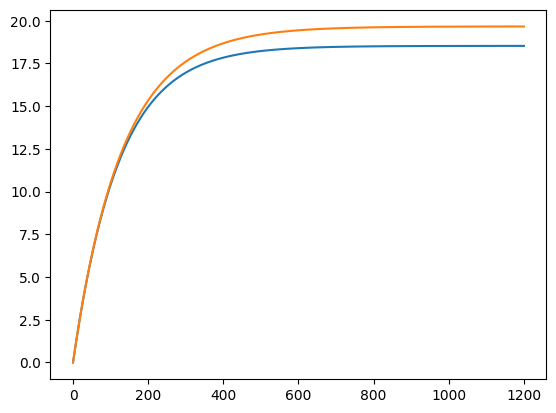

In [17]:
cstates = np.zeros((1201, 4), dtype=float)
dstates = np.zeros((1201, 4), dtype=float)

u = [100.0, 0.0]

for i in range(1200):
    cstates[i + 1] = cstates[i] + system_dynamics(cstates[i] + x_s, u_s + jnp.array(u), d_s, default_params)
    dstates[i + 1] = dsys.A @ dstates[i] + dsys.B @ np.array(u)

plt.plot((dstates / default_params[pidx["area_tank"]])[:, 0])
plt.plot((cstates/ default_params[pidx["area_tank"]])[:, 0])

## 5.5

In [18]:
H = markov_parameters(dsys.A, dsys.B, dsys.C, 1028)

H.shape

(1029, 2, 2)

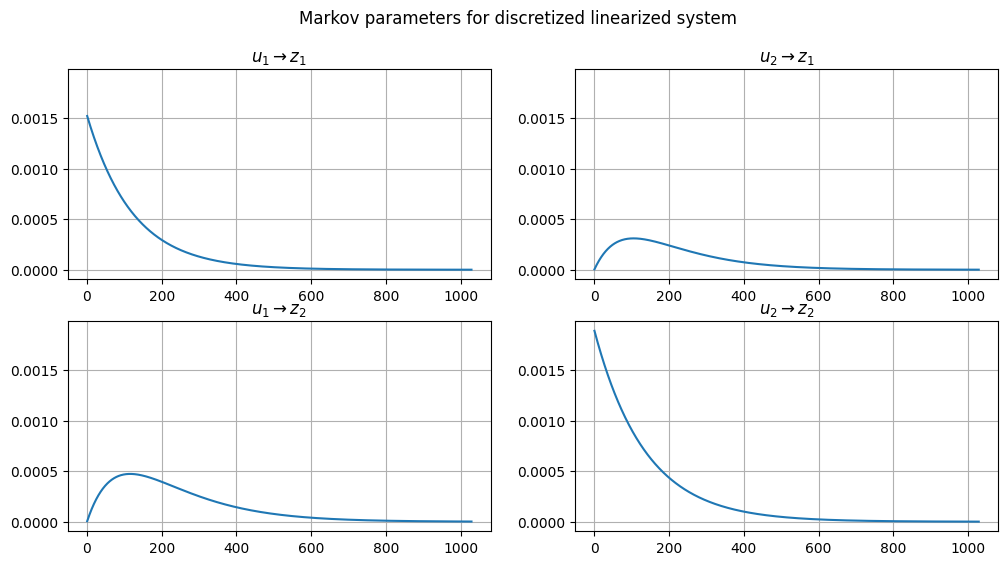

In [19]:
plot_markov_params(
    H, 
    "Markov parameters for discretized linearized system",
    "report/figures/problem5/markovparameters.pdf",
)